# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
We now have a quadratic network working, let's leverage its output with a public NN to make better predictions!

# 2 Quadratic model improvements


We will now use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from learn import main, train, test, show_results, show_confusion_matrix

In [7]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 60
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

## 2.1 Proof of interest on the family task
What we are primarily interested in is optimising the network with a public part on char recognition task. However, as we already have a high accuracy there is no massive improvement to expect. We will hence start by the family recognition task on which we perform less well.

### 2.1.1 Quadratic baseline
We recall the base quadratic model that we have seen previously.

In [8]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)

Let's train it with the hyperparameters tuned, using the conclusions of Part 2.

In [9]:
results = {}
results['QuadNet'], pred_labels = main(model=QuadNet(5), model_type='quad', args=Parser(), task='family', return_pred_label=True)

Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.809040
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.599153
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.423586
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.538562

Test set: Average loss: 1.3016, Accuracy: 4615/10000 (46.15%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.418864
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.346861
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.329638
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.242299

Test set: Average loss: 1.1712, Accuracy: 5354/10000 (53.54%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.205652
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.332187
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.238666
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.333395

Test set: Average loss: 1.1000, Accuracy: 5590/10000 (55.90%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.297452
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.134939
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.10376

For the sake of curiosity, let's print the confusion matrix for the base model

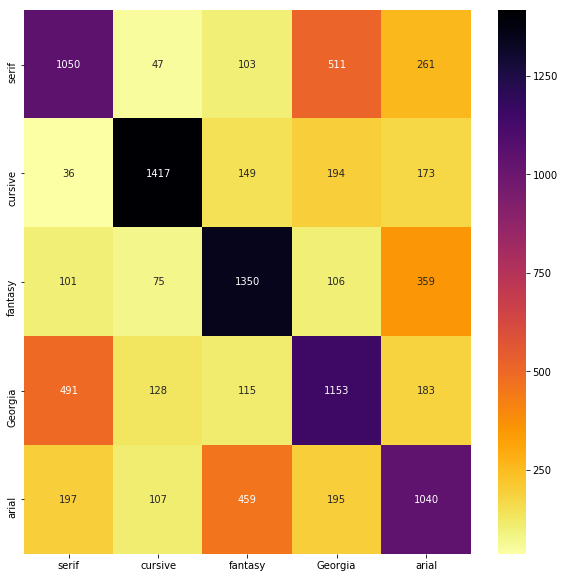

In [10]:
show_confusion_matrix(pred_labels, task='family')

### 2.1.2 Quadratic + Linear1
Here we try to add linear wider model on top of the input, which consists or 2 linear units and 2 relu activations.

In [24]:
class QuadLinear1Net(nn.Module):
    def __init__(self, output_size):
        super(QuadLinear1Net, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)
        
        # --- Linear
        self.lin1 = nn.Linear(output_size, 4*output_size)
        self.lin2 = nn.Linear(4*output_size, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        # --- Linear
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return F.log_softmax(x, dim=1)

In [25]:
results[f'QuadNet + Linear1'] = main(model=QuadLinear1Net(5), model_type='quad', args=Parser(), task='family')


Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.775788
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.770184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.734697
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.708210

Test set: Average loss: 1.5493, Accuracy: 2929/10000 (29.29%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.662042
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.603333
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.666451
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.471670

Test set: Average loss: 1.3920, Accuracy: 3783/10000 (37.83%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.535431
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.521952
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.450468
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.429659

Test set: Average loss: 1.3072, Accuracy: 4292/10000 (42.92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.423967
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.349802
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.20654

Train Epoch: 32 [19200/60000 (32%)]	Loss: 0.805581
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.755283
Train Epoch: 32 [57600/60000 (96%)]	Loss: 0.862373

Test set: Average loss: 0.7583, Accuracy: 6861/10000 (68.61%)

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.889574
Train Epoch: 33 [19200/60000 (32%)]	Loss: 0.796078
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.741352
Train Epoch: 33 [57600/60000 (96%)]	Loss: 0.890069

Test set: Average loss: 0.7415, Accuracy: 6965/10000 (69.65%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.875377
Train Epoch: 34 [19200/60000 (32%)]	Loss: 0.831117
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.884207
Train Epoch: 34 [57600/60000 (96%)]	Loss: 0.674550

Test set: Average loss: 0.7445, Accuracy: 6933/10000 (69.33%)

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.635180
Train Epoch: 35 [19200/60000 (32%)]	Loss: 0.729051
Train Epoch: 35 [38400/60000 (64%)]	Loss: 0.915061
Train Epoch: 35 [57600/60000 (96%)]	Loss: 0.766116

Test set: Average loss: 0.7253, Accuracy: 6974/10000 (69.

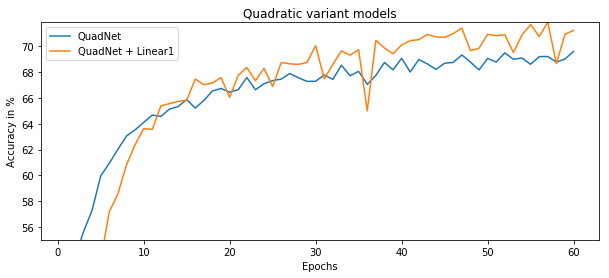

In [26]:
show_results(results, 'Quadratic variant models', ymin=55)

### 2.1.3 Quadratic + Linear2
Let's try to a wiser Linear model which performs quite well on MNIST too

In [27]:
class QuadLinear2Net(nn.Module):
    def __init__(self, output_size):
        super(QuadLinear2Net, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)
        
        # --- Junction
        self.jct = nn.Linear(output_size, 784)
        
        # --- Linear 2
        self.fc1 = nn.Linear(784, 548)
        self.bc1 = nn.BatchNorm1d(548)
        
        self.fc2 = nn.Linear(548, 252)
        self.bc2 = nn.BatchNorm1d(252)
        
        self.fc3 = nn.Linear(252, output_size)
        

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        # --- Junction
        x = self.jct(x)
        x = x.view((-1, 784))
        
        # --- Linear
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        
        return F.log_softmax(x, dim=1)

In [29]:
results[f'QuadNet + Linear2'] = main(model=QuadLinear2Net(5), model_type='quad', args=Parser(), task='family')


Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 6.784455
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.726686
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.544018
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.640775

Test set: Average loss: 1.4767, Accuracy: 3292/10000 (32.92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.620876
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.634840
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.574660
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.422879

Test set: Average loss: 1.3911, Accuracy: 3837/10000 (38.37%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.581205
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.501402
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.333578
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.429664

Test set: Average loss: 1.2392, Accuracy: 4786/10000 (47.86%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.314959
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.355232
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.41107

Train Epoch: 32 [19200/60000 (32%)]	Loss: 0.829914
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.798354
Train Epoch: 32 [57600/60000 (96%)]	Loss: 0.935163

Test set: Average loss: 0.8973, Accuracy: 6566/10000 (65.66%)

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.854122
Train Epoch: 33 [19200/60000 (32%)]	Loss: 0.972557
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.936547
Train Epoch: 33 [57600/60000 (96%)]	Loss: 0.995497

Test set: Average loss: 0.8686, Accuracy: 6652/10000 (66.52%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.912700
Train Epoch: 34 [19200/60000 (32%)]	Loss: 1.031416
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.921068
Train Epoch: 34 [57600/60000 (96%)]	Loss: 0.890267

Test set: Average loss: 0.8613, Accuracy: 6662/10000 (66.62%)

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.798796
Train Epoch: 35 [19200/60000 (32%)]	Loss: 0.945217
Train Epoch: 35 [38400/60000 (64%)]	Loss: 1.010099
Train Epoch: 35 [57600/60000 (96%)]	Loss: 0.793893

Test set: Average loss: 0.8652, Accuracy: 6723/10000 (67.

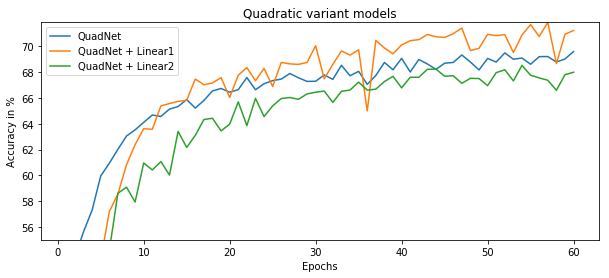

In [30]:
show_results(results, 'Quadratic variant models', ymin=55)

As this shows, choosing the right network is crucial to expect improvements.

### 2.1.4 Quadratic + Conv1
Here we try to add a CNN wider model on top of the input, which consists of the CNN block used previously and which is provided in the [official Pytorch tutorial on MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [42]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 40
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

In [43]:
class QuadConv1Net(nn.Module):
    def __init__(self, output_size):
        super(QuadConv1Net, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)
        
        # --- Junction
        self.jct = nn.Linear(output_size, 784)
        
        # --- CNN
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [44]:
model = QuadConv1Net(5)
results['QuadNet + Conv1'], pred_labels = main(model=model, args=Parser(), model_type='quad', task='family', , return_pred_label=True)

Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.767294
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.761317
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.754163
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.750296

Test set: Average loss: 1.6061, Accuracy: 2436/10000 (24.36%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.745213
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.744235
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.737095
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.636252

Test set: Average loss: 1.5393, Accuracy: 3007/10000 (30.07%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.678540
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.603785
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.514740
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.604542

Test set: Average loss: 1.4324, Accuracy: 3455/10000 (34.55%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.532585
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.478976
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.38317

Train Epoch: 32 [19200/60000 (32%)]	Loss: 0.636423
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.544311
Train Epoch: 32 [57600/60000 (96%)]	Loss: 0.623626

Test set: Average loss: 0.5512, Accuracy: 7804/10000 (78.04%)

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.511012
Train Epoch: 33 [19200/60000 (32%)]	Loss: 0.634381
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.559141
Train Epoch: 33 [57600/60000 (96%)]	Loss: 0.574349

Test set: Average loss: 0.5407, Accuracy: 7813/10000 (78.13%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.571148
Train Epoch: 34 [19200/60000 (32%)]	Loss: 0.570894
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.499673
Train Epoch: 34 [57600/60000 (96%)]	Loss: 0.392294

Test set: Average loss: 0.5362, Accuracy: 7782/10000 (77.82%)

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.513758
Train Epoch: 35 [19200/60000 (32%)]	Loss: 0.493750
Train Epoch: 35 [38400/60000 (64%)]	Loss: 0.481929
Train Epoch: 35 [57600/60000 (96%)]	Loss: 0.589551

Test set: Average loss: 0.5085, Accuracy: 7936/10000 (79.

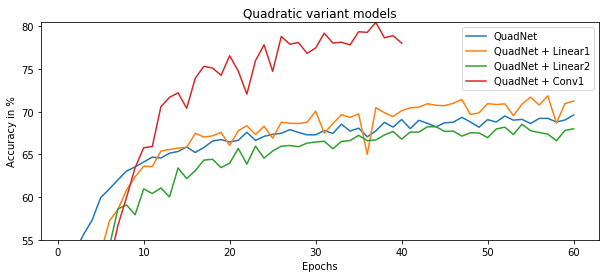

In [45]:
show_results(results, 'Quadratic variant models', ymin=55)

The CNN configuration really outperforms the linear ones, which we could have expected because the CNN alone was doing really good. What's interesting is that it managed to exploit the private quadratic model to leverage its 5 bits output and achieve a very good performance.

For the sake of curiosity, let's build the confusion matrix to understand if there is an obvious weakness on this very model on family/fonts recognition.

In [ ]:
show_confusion_matrix(pred_labels, task='family')

This shows as a conclusion that we can expect some improvements on the global accuracy if we use a public network to leverage (and optimize) the output of the private quadratic network.

### Subsidiary question
The CNN modifed the private model in depth. If we remove the CNN part, can we expect some interesting behaviour from the private part?

In [ ]:
def private_forward(self, x):
    x = x.view(-1, 784)
    x = self.proj1(x)
    x = x * x
    x = self.diag1(x)
    return F.log_softmax(x, dim=1)

model.private_forward = private_forward